# Simple Classifier Transformer
## In this notebook I'm going to Download, Preprocess, Model and train a Simple VIT.

## importing Libraries
1. `torch, torch.nn, torch.optim, torch.utils.data` and `torchvision` to create model and preprocessors
2. `numpy` to change image types if needed
3. `matplotlib` to plot and show the Data and loss curves
4. `os` to count cpu
5. `requests` to download dataset
6. `zipfile` to unzip dataset
7. `pathlib` to control and work with the directories

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image

## Download Dataset
This dataset contains 3 classes of 600 food images, `Pizza`, `Steak` and `Sushi`.

* 450 train images
* 150 test images

In [2]:
data_path  = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exists...Stop Downloading")
else:
  print("Downloading the data...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download the dataset
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    data = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    f.write(data.content)

  # Unzipping the dataset
  print("Unzipping the files...")
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_file:
    zip_file.extractall(image_path)

print("Process finished successfully...")

Unzipping the files...
Process finished successfully...


In [3]:
def walk_through_dir(dir_path):
  """Walk through directory path and returning its contents."""
  for dirpath, dirnames, dirfiles in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(dirfiles)} files in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 files in data/pizza_steak_sushi
There are 3 directories and 0 files in data/pizza_steak_sushi/test
There are 0 directories and 46 files in data/pizza_steak_sushi/test/sushi
There are 0 directories and 46 files in data/pizza_steak_sushi/test/pizza
There are 0 directories and 58 files in data/pizza_steak_sushi/test/steak
There are 3 directories and 0 files in data/pizza_steak_sushi/train
There are 0 directories and 150 files in data/pizza_steak_sushi/train/sushi
There are 0 directories and 154 files in data/pizza_steak_sushi/train/pizza
There are 0 directories and 146 files in data/pizza_steak_sushi/train/steak


In [4]:
import random
def plot_images(image_paths, seed=None):
    # Set seed
    if seed:
        random.seed(seed)

    # Create figure
    plt.figure(figsize=(16, 9))

    # Get random images
    random_samples = random.sample(list(image_paths.glob("*/*/*.jpg")), k=5)

    for i, image in enumerate(random_samples):  # Added enumerate to get index
        img = Image.open(image)
        img_class = image.parent.stem  # Removed parentheses

        # Plot the image
        plt.subplot(1, 5, i+1)  # Using loop index instead of image
        plt.imshow(img)
        plt.title(img_class)  # Added title to show the class
        plt.axis(False)

    plt.show()  # Show the plot

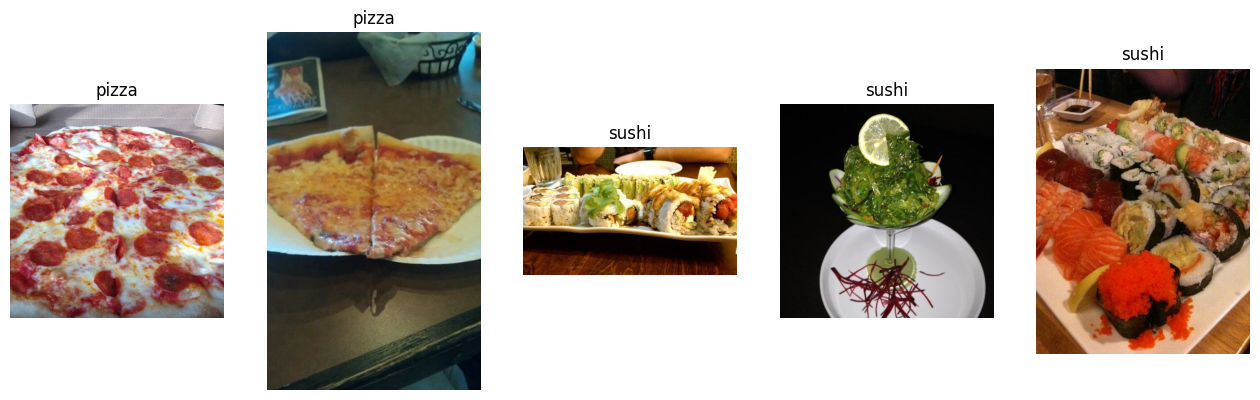

In [5]:
plot_images(image_path)

## Creating Torch Dataset

In [6]:
train_dir = image_path / "train"
test_dir  = image_path / "test"

transformer = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transformer)
test_dataset  = datasets.ImageFolder(root=test_dir , transform=transformer)

print(f"We have {len(train_dataset)} images to train our model, and {len(test_dataset)} images to test our model.")

We have 450 images to train our model, and 150 images to test our model.


In [7]:
img_sample = train_dataset[0][0]
lbl_sample = train_dataset[0][1]

"First image shape:", img_sample.shape, "First image label:", lbl_sample

('First image shape:', torch.Size([3, 224, 224]), 'First image label:', 0)

## Creating DataLoaders

In [8]:
num_workers = os.cpu_count()

batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, shuffle=True , num_workers=num_workers, batch_size=batch_size)
test_dataloader  = DataLoader(dataset=test_dataset , shuffle=False, num_workers=num_workers, batch_size=batch_size)

print(f"We have {len(train_dataloader)} batches of {batch_size} in train dataloader.")
print(f"We have {len(test_dataloader)}  batches of {batch_size} in test  dataloader.")

We have 15 batches of 32 in train dataloader.
We have 5  batches of 32 in test  dataloader.


## Vision Transformer (ViT) Implementation

The Vision Transformer (ViT) architecture treats images as sequences of patches and processes them using a transformer encoder, similar to how text is processed in NLP models.

### Key Components

#### 1. PatchEmbedding Class

The `PatchEmbedding` class handles:
- **Image to Patch Conversion**: Uses a 2D convolution (`nn.Conv2d`) to split the input image into fixed-size patches (16x16 pixels in this implementation)
- **Linear Projection**: Projects each flattened patch into an embedding space of dimension `embed_dim`
- **[CLS] Token**: Adds a learnable classification token that aggregates information from all patches
- **Positional Encoding**: Implements sinusoidal positional embeddings to maintain spatial information

##### Positional Encoding Details:
Uses the standard transformer positional encoding formula:

PE(pos, 2i) = sin(pos/10000^(2i/d_model))

PE(pos, 2i+1) = cos(pos/10000^(2i/d_model))

where `pos` is the position and `i` is the dimension.

#### 2. TransformerEncoder Class

The main transformer encoder that processes the patch embeddings through:
1. **Patch Embedding Layer**: Converts input image to patch embeddings
2. **Multi-head Self-Attention**: Computes attention weights between all patches
3. **Layer Normalization**: Applied after both attention and MLP blocks
4. **MLP Block**: Two linear layers with GELU activation and expansion factor of 4
5. **Classification Head**: Uses the [CLS] token embedding for final classification

### Forward Pass Flow

1. Input image (B, C, H, W) → Patch embedding
2. Add [CLS] token and positional encoding
3. Process through self-attention with residual connection
4. Process through MLP with residual connection
5. Use [CLS] token embedding for classification

Note: This is a minimal implementation that demonstrates the core ViT concepts. Full ViT implementations typically include multiple transformer layers and more sophisticated components.

In [9]:
!pip install torchinfo

In [10]:
# Setting the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
image_size = 224
patch_size = 16
num_channels = 3
embed_dim = 196
num_heads = 7
num_classes = 3

num_patches = (image_size // patch_size) ** 2
patch_dim = num_channels * (patch_size ** 2)

print(num_patches)
print(patch_dim)

196
768


In [179]:
import math
class PatchEmbedding(nn.Module):
    def __init__(self, num_patches, patch_dim, embed_dim, device):
        super().__init__()
        self.conv2d = nn.Conv2d(in_channels=3, out_channels=768,
                              kernel_size=(16,16), stride=(16,16))
        self.projection = nn.Linear(patch_dim, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # [CLS] Token
        self.pe = self.create_positional_encoding(num_patches + 1, embed_dim)  # Positional encoding

    def create_positional_encoding(self, num_patches, embed_dim):
        pe = torch.zeros(num_patches, embed_dim).to(device)
        for pos in range(num_patches):
            for i in range(0, embed_dim, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/embed_dim)))
        pe = pe.unsqueeze(0)
        return pe

    def forward(self, x):
        batch_size = x.size(0)  # Get batch size from input
        x = self.conv2d(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        x = self.projection(x)  # (batch, num_patches, embed_dim)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # Expand to batch size
        x = torch.cat([cls_tokens, x], dim=1)  # Simply concatenate, no slicing needed

        x += self.pe
        return x

In [180]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_classes, device):
        super().__init__()
        self.patch_embed = PatchEmbedding(num_patches, patch_dim, embed_dim, device)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.classifier = nn.Linear(embed_dim, num_classes)
    def forward(self, x):
        x = self.patch_embed(x)
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        x = self.norm(x)

        mlp_output = self.mlp(x)
        x = x + mlp_output
        x = self.norm(x)

        logits = self.classifier(x[:, 0, :])
        return logits

In [184]:
class AdamWarmUp:
  def __init__(self, model_size, warmup_size, optimizer):
    # Initialize learning rate scheduler parameters
    self.model_size   = model_size
    self.warmup_size  = warmup_size
    self.optimizer    = optimizer
    self.current_step = 0
    self.lr          = 0

  def get_lr(self):
    # Calculate learning rate with warmup
    return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_size ** (-1.5))

  def step(self):
    # Update learning rate and optimizer step
    self.current_step += 1
    lr = self.get_lr()
    for param_group in self.optimizer.param_groups:
      param_group['lr'] = lr
    self.lr = lr
    self.optimizer.step()

In [181]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = TransformerEncoder( embed_dim, num_heads, num_classes, device).to(device)

In [182]:
# Dsiplaying our model informations
from torchinfo import summary
summary(model=model, input_size=torch.rand(32, 3, 224, 224).shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [32, 3]                   --
├─PatchEmbedding: 1-1                    [32, 197, 196]            196
│    └─Conv2d: 2-1                       [32, 768, 14, 14]         590,592
│    └─Linear: 2-2                       [32, 196, 196]            150,724
├─MultiheadAttention: 1-2                [32, 197, 196]            154,448
├─LayerNorm: 1-3                         [32, 197, 196]            392
├─Sequential: 1-4                        [32, 197, 196]            --
│    └─Linear: 2-3                       [32, 197, 784]            154,448
│    └─GELU: 2-4                         [32, 197, 784]            --
│    └─Linear: 2-5                       [32, 197, 196]            153,860
├─LayerNorm: 1-5                         [32, 197, 196]            (recursive)
├─Linear: 1-6                            [32, 3]                   591
Total params: 1,205,251
Trainable params: 1,205,

In [183]:
X, y = next(iter(train_dataloader))
X = X.to(device)
out = model(X)
out.shape

torch.Size([32, 3])

In [185]:
# Set Criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0)
transformer_optimizer = AdamWarmUp(model_size=embed_dim, warmup_size=4000, optimizer=optimizer)

## Train Model

In [186]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def train(model: torch.nn.Module, criterion: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          train_data: torch.utils.data.DataLoader,
          test_data: torch.utils.data.DataLoader,
          epochs=5,
          device="cpu",
          ):

  model_results = {
        'train_loss' : [],
        'train_acc'  : [],
        'test_loss'  : [],
        'test_acc'   : [],
        "train_time": 0
  }

  start_train_time = timer()

  for epoch in tqdm(range(epochs)):
    print(f"\nEpoch {epoch+1}\n--------------------")

    # Set the model on train mode.
    model.train()

    train_loss, train_acc = 0, 0
    test_loss , test_acc  = 0, 0

    for batch, (X, y) in enumerate(train_data):

      # 1. Send data into device.
      X, y = X.to(device), y.to(device)

      # 2. Pass data through the model.
      y_pred = model(X)

      # 3. Calculate the model error.
      loss = criterion(y_pred, y)
      train_loss += loss.item()

      # 4. optimizer zero grad.
      optimizer.optimizer.zero_grad()

      # 5. loss backward.
      loss.backward()

      # 6. optimizer step.
      optimizer.step()

      # 7. Calculate the output.
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

    train_loss /= len(train_data)
    train_acc  /= len(train_data)

    # Test phase
    model.eval()
    with torch.inference_mode():
      for batch, (X, y) in enumerate(test_data):
        # 1. Send data into device.
        X, y = X.to(device), y.to(device)

        # 2. Pass data through the model.
        test_pred = model(X)

        # 3. Calculate the model error.
        loss = criterion(test_pred, y)
        test_loss += loss.item()

        # 4. Calculate the output.
        test_pred_classes = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
        test_acc += (test_pred_classes == y).sum().item()/len(test_pred_classes)

      test_loss /= len(test_data)
      test_acc  /= len(test_data)

    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")
    print(f"Test loss : {train_loss:.4f} | Test accuracy : {test_acc:.4f}")

    model_results["train_loss"].append(train_loss)
    model_results["train_acc"].append(train_acc)
    model_results["test_loss"].append(test_loss)
    model_results["test_acc"].append(test_acc)

  end_train_time = timer()
  total_train_time = end_train_time - start_train_time
  print(f"Total train time: {total_train_time:.4f} seconds" )
  return model_results

In [187]:
device

'cuda'

In [188]:
model_results = train(model=model, criterion=criterion,
      optimizer=transformer_optimizer,
      train_data=train_dataloader,
      test_data=test_dataloader,
      epochs=15,
      device=device)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1
--------------------
Train loss: 1.2243 | Train accuracy: 0.3438
Test loss : 1.2243 | Test accuracy : 0.3500

Epoch 2
--------------------
Train loss: 1.1835 | Train accuracy: 0.3438
Test loss : 1.1835 | Test accuracy : 0.3500

Epoch 3
--------------------
Train loss: 1.1281 | Train accuracy: 0.3438
Test loss : 1.1281 | Test accuracy : 0.3500

Epoch 4
--------------------
Train loss: 1.1053 | Train accuracy: 0.3292
Test loss : 1.1053 | Test accuracy : 0.2875

Epoch 5
--------------------
Train loss: 1.0984 | Train accuracy: 0.3521
Test loss : 1.0984 | Test accuracy : 0.2875

Epoch 6
--------------------
Train loss: 1.1020 | Train accuracy: 0.2833
Test loss : 1.1020 | Test accuracy : 0.2875

Epoch 7
--------------------
Train loss: 1.0959 | Train accuracy: 0.3833
Test loss : 1.0959 | Test accuracy : 0.2875

Epoch 8
--------------------
Train loss: 1.1024 | Train accuracy: 0.3521
Test loss : 1.1024 | Test accuracy : 0.2875

Epoch 9
--------------------
Train loss: 1.1093 | Train

## Plot The Loss And Accuracy Curves

In [189]:
def plot_loss_and_acc(model_results: dict):

  train_loss = model_results["train_loss"]
  train_acc = model_results["train_acc"]
  test_loss = model_results["test_loss"]
  test_acc = model_results["test_acc"]

  epochs = range(len(train_loss))

  plt.figure(figsize=(16, 8))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="Train loss")
  plt.plot(epochs, test_loss , label="Test loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label="Train accuracy")
  plt.plot(epochs, test_acc, label="Test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

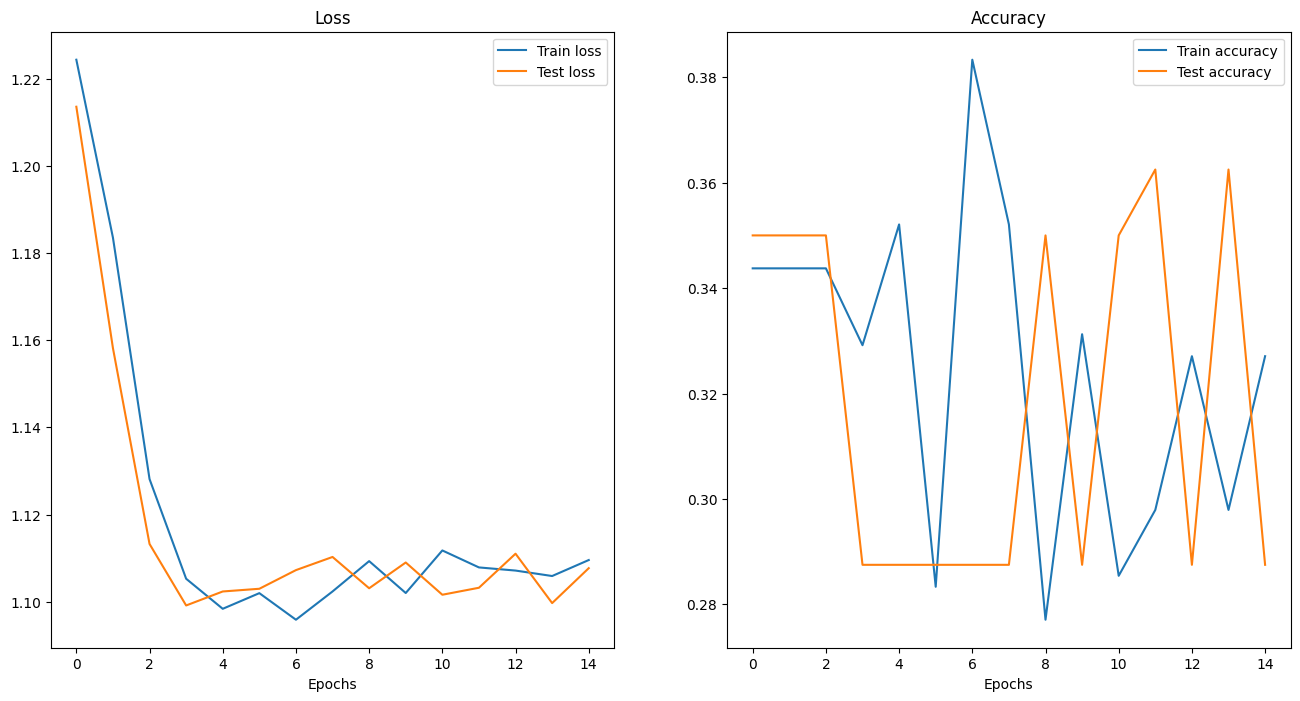

In [190]:
plot_loss_and_acc(model_results)

## Data Augmentation
Below we are going to
1. Augment our dataset.
2. Combine the augmented data with simple data.
3. Then train a new instance of model with combined data.

In [197]:
from torch.utils.data import ConcatDataset

# Create new transformer
transformer_aug = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

print("Length simple dataset: ", len(train_dataset))

# Create augmented dataset
train_dataset_augmented = datasets.ImageFolder(root=train_dir, transform=transformer_aug)
print("Length augmented dataset: ", len(train_dataset_augmented))

# Combine simple dataset with augmented dataset
combined_datasets = ConcatDataset([train_dataset, train_dataset_augmented])
print("Length combined datasets: ", len(combined_datasets))

# Create dataloader
train_dataloader_augmented = DataLoader(dataset=combined_datasets, shuffle=True, num_workers=num_workers, batch_size=batch_size)

Length simple dataset:  450
Length augmented dataset:  450
Length combined datasets:  900


In [198]:
# Create new instance from Classifier
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = TransformerEncoder(embed_dim, num_heads, num_classes, device).to(device)

In [199]:
# Set Criterion
criterion_2 = nn.CrossEntropyLoss()

# Set optimizer
optimizer_2 = torch.optim.Adam(params=model_2.parameters(), lr=0)
transformer_optimizer_2 = AdamWarmUp(model_size=embed_dim,
                                     warmup_size=4000,
                                     optimizer=optimizer_2)

In [200]:
device

'cuda'

In [201]:
model_2_results = train(model=model_2, criterion=criterion_2,
      optimizer=transformer_optimizer_2,
      train_data=train_dataloader_augmented,
      test_data=test_dataloader,
      epochs=15,
      device=device)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1
--------------------
Train loss: 1.2068 | Train accuracy: 0.3308
Test loss : 1.2068 | Test accuracy : 0.3500

Epoch 2
--------------------
Train loss: 1.1162 | Train accuracy: 0.3373
Test loss : 1.1162 | Test accuracy : 0.2875

Epoch 3
--------------------
Train loss: 1.1002 | Train accuracy: 0.3222
Test loss : 1.1002 | Test accuracy : 0.2875

Epoch 4
--------------------
Train loss: 1.1035 | Train accuracy: 0.3244
Test loss : 1.1035 | Test accuracy : 0.3500

Epoch 5
--------------------
Train loss: 1.1008 | Train accuracy: 0.3545
Test loss : 1.1008 | Test accuracy : 0.3500

Epoch 6
--------------------
Train loss: 1.1102 | Train accuracy: 0.3136
Test loss : 1.1102 | Test accuracy : 0.3625

Epoch 7
--------------------
Train loss: 1.1071 | Train accuracy: 0.3050
Test loss : 1.1071 | Test accuracy : 0.3500

Epoch 8
--------------------
Train loss: 1.1016 | Train accuracy: 0.3513
Test loss : 1.1016 | Test accuracy : 0.2875

Epoch 9
--------------------
Train loss: 1.1040 | Train

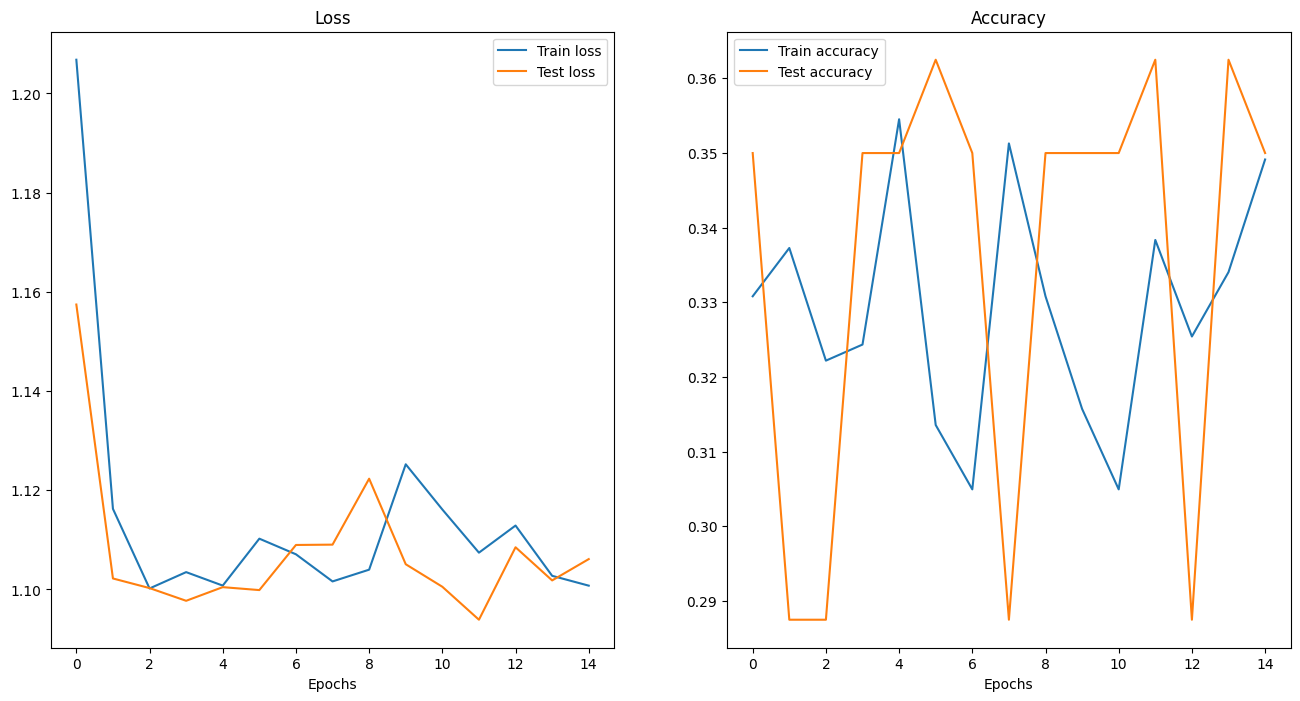

In [202]:
plot_loss_and_acc(model_2_results)